In [1]:
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import nd
from mxnet import autograd
import numpy as np
import mxnet as mx
import pickle as p
from mxnet import image
from time import time
import matplotlib.pyplot as plt
ctx = mx.gpu()

In [2]:
def load_cifar(route = '/home/sinyer/python/data/cifar-10-batches-py', train_num = 50000, test_num = 10000):
    def load_batch(filename):
        with open(filename, 'rb')as f:
            data_dict = p.load(f, encoding='latin1')
            X = data_dict['data']
            Y = data_dict['labels']
            X = X.reshape(10000, 3, 32,32).astype("float")
            Y = np.array(Y)
            return X, Y
    def load_labels(filename):
        with open(filename, 'rb') as f:
            label_names = p.load(f, encoding='latin1')
            names = label_names['label_names']
            return names
    label_names = load_labels(route + "/batches.meta")
    x1, y1 = load_batch(route + "/data_batch_1")
    x2, y2 = load_batch(route + "/data_batch_2")
    x3, y3 = load_batch(route + "/data_batch_3")
    x4, y4 = load_batch(route + "/data_batch_4")
    x5, y5 = load_batch(route + "/data_batch_5")
    test_pic, test_label = load_batch(route + "/test_batch")
    train_pic = np.concatenate((x1, x2, x3, x4, x5))
    train_label = np.concatenate((y1, y2, y3, y4, y5))
    train_pic = train_pic[:train_num].astype('float32')/255
    train_label = train_label[:train_num].astype('float32')
    test_pic = test_pic[:test_num].astype('float32')/255
    test_label = test_label[:test_num].astype('float32')
    return train_pic, train_label, test_pic, test_label

train_pic, train_label, test_pic, test_label = load_cifar()

batch_size = 128
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_pic, train_label), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_pic, test_label), batch_size, shuffle=False)

In [3]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = tf_test(data).as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

aug_train = image.CreateAugmenter(data_shape=(3, 32, 32), 
                rand_crop=True, rand_mirror=True,
                mean=np.array([0.4914, 0.4822, 0.4465]), 
                std=np.array([0.2023, 0.1994, 0.2010]))

aug_test = image.CreateAugmenter(data_shape=(3, 32, 32), 
                mean=np.array([0.4914, 0.4822, 0.4465]), 
                std=np.array([0.2023, 0.1994, 0.2010]))

def apply(img, auglist):
    for aug in auglist:
        img = aug(img)
    return img

def tf_test(data):
    data = nd.transpose(data, (0,2,3,1))
    data = nd.stack(*[apply(d, aug_test) for d in data])
    data = nd.transpose(data, (0,3,1,2))
    return data

def tf_train(data): 
    data = nd.pad(data, pad_width=(0,0,0,0,2,2,2,2),mode='constant',constant_value=0)
    data = nd.transpose(data, (0,2,3,1))
    data = nd.stack(*[apply(d, aug_train) for d in data])
    data = nd.transpose(data, (0,3,1,2))
    return data

In [4]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=50, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128, activation="relu"),
        nn.Dense(10)
    )
net.initialize(ctx=ctx)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})

E 0; L 1.817020; Tr_acc 0.338787; Te_acc 0.393592; T 15.954365
E 10; L 1.421623; Tr_acc 0.518015; Te_acc 0.539656; T 15.024546
E 20; L 1.380755; Tr_acc 0.538331; Te_acc 0.511472; T 15.068041
E 30; L 1.359921; Tr_acc 0.550452; Te_acc 0.542029; T 15.162015
E 40; L 1.347732; Tr_acc 0.558752; Te_acc 0.530558; T 14.925549
E 50; L 1.089433; Tr_acc 0.640141; Te_acc 0.648734; T 15.032742
E 60; L 0.853092; Tr_acc 0.716372; Te_acc 0.702334; T 15.165643
E 70; L 0.810562; Tr_acc 0.732257; Te_acc 0.718651; T 14.899151
E 80; L 0.666439; Tr_acc 0.778700; Te_acc 0.762856; T 14.796510
E 90; L 0.505821; Tr_acc 0.825196; Te_acc 0.780657; T 15.410143
Tr_acc 0.839206; Te_acc 0.787975


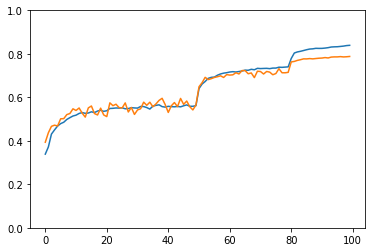

In [5]:
epochs = 100

a = []
b = []
for epoch in range(epochs):
    if epoch == 50:
        trainer.set_learning_rate(0.05)
    if epoch == 80:
        trainer.set_learning_rate(0.005)
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = tf_train(data).as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        trainer.step(data.shape[0])
        train_loss += nd.mean(l).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%10 == 0:
        print("E %d; L %f; Tr_acc %f; Te_acc %f; T %f" % (epoch, train_loss / batch, train_acc / batch, test_acc, time() - start))
print("Tr_acc %f; Te_acc %f" % (train_acc / batch, test_acc))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0,1)
plt.show()